In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import gc
import os 
import sys
sys.path.insert(0, "/Users/andypark/Desktop/PhD/fpfs")
import fpfs
import impt
import fitsio
import galsim
import numpy as np
import matplotlib.pylab as plt
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import ImageGrid

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally

# README
This notebook show the test on isolated galaxies (center known)

2023/04/15 13:27:44 ---  Processing for g1-2222, and shears for four redshift bins are [0.02 0.02 0.02 0.02].


Making Basic Simulation. ID: 2


10

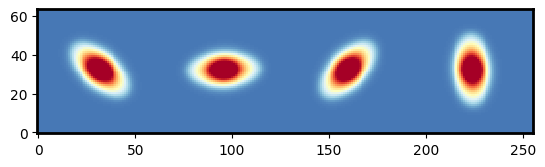

In [2]:
shear_value = 0.02
scale = 0.168
outDir='galaxy_basicCenter_psf60'
psfInt = galsim.Moffat(
    beta=3.5, fwhm=0.6, trunc=0.6 * 4.0
).shear(e1=0.02, e2=-0.02)
psfData = psfInt.shift(0.5 * scale, 0.5 * scale).drawImage(nx=64, ny=64, scale=scale).array

# Four Galaxies to cancel spin-2 and spin-4 ansiotropies
# spin-2 is shape noise in diagnonal elements of shear response matrix
# spin-4 is shape noise in diagnonal and of-diagnoal elements of shear response matrix, 
# but an order of magnitude smaller than spin-2
gal_data = fpfs.simutil.make_basic_sim(
    outDir,psf_obj=psfInt,gname='g1-2222',
    ind0=2,ny=64,nx=256, scale=scale,
    do_write=False,return_array=True,
    shear_value = shear_value)
plt.close()
plt.imshow(gal_data,aspect='equal',cmap='RdYlBu_r',origin='lower',interpolation='None',\
             norm=simple_norm(gal_data,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=0.3))
gc.collect()

In [3]:
# Now we measure shear
rcut = 32

# fake detection
indX = np.arange(32, 256, 64)
indY = np.arange(32, 64, 64)
inds = np.meshgrid(indY, indX, indexing="ij")
coords = np.array(
    np.zeros(inds[0].size),
    dtype=[("fpfs_y", "i4"), ("fpfs_x", "i4")],
)
coords["fpfs_y"] = np.ravel(inds[0])
coords["fpfs_x"] = np.ravel(inds[1])
imgList = [
    gal_data[
        cc["fpfs_y"] - rcut : cc["fpfs_y"] + rcut,
        cc["fpfs_x"] - rcut : cc["fpfs_x"] + rcut,
    ]
    for cc in coords
]

# 2nd Order

In [4]:
fpTask  =   fpfs.image.measure_source(psfData, sigma_arcsec=0.7, nnord=6)
mms =  fpTask.measure(imgList)
fitsio.write('a.fits', mms)

2023/04/15 13:27:44 ---  Gaussian kernel in configuration space: sigma= 0.7000 arcsec


In [5]:
wconst = 2.0
test_fname = "a.fits"
cat = impt.fpfs4.read_catalog(test_fname)
params = impt.fpfs4.FpfsParams(Const=wconst)

# initialize the function of ellipticty
ell1 = impt.fpfs4.nlobs.FpfsE1(params)
ell2 = impt.fpfs4.nlobs.FpfsE2(params)

2023/04/15 13:27:45 ---  Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/04/15 13:27:45 ---  Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/04/15 13:27:45 ---  Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023/04/15 13:27:45 ---  Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [6]:
e1_array = ell1.evaluate(cat)
print(ell1.evaluate(cat))
print(mms['fpfs_M22c']/(mms['fpfs_M00'] + wconst))

[ 0.02069742  0.12795444 -0.00482232 -0.11496067]
[ 0.02069742  0.12795444 -0.00482232 -0.11496067]


In [7]:
# shear response of e1
de1_dg1 = impt.RespG1(ell1)
resp_array = de1_dg1.evaluate(cat)
print(resp_array)
shear=np.average(e1_array)/np.average(resp_array)

[0.35085413 0.37334159 0.35037852 0.36908162]


In [8]:
print('Input shear is: %.6f' %shear_value)
print('Estimated shear is: %.6f' %shear)

Input shear is: 0.020000
Estimated shear is: 0.019997


# 4th Order

In [9]:
fpTask  =   fpfs.image.measure_source(psfData, sigma_arcsec=0.7, nnord=6)
mms =  fpTask.measure(imgList)
fitsio.write('a.fits', mms)

2023/04/15 13:27:45 ---  Gaussian kernel in configuration space: sigma= 0.7000 arcsec


In [10]:
wconst = 2.0
test_fname = "a.fits"
cat = impt.fpfs4.read_catalog(test_fname)
params = impt.fpfs4.FpfsParams(Const=wconst)

# initialize the function of ellipticty
ell1 = impt.fpfs4.nlobs.FpfsE41(params)
ell2 = impt.fpfs4.nlobs.FpfsE42(params)

In [11]:
e1_array = ell1.evaluate(cat)
print(ell1.evaluate(cat))
print(mms['fpfs_M42c']/(mms['fpfs_M00'] + wconst))

[-0.00894136 -0.05497615  0.00212656  0.04926409]
[-0.00894136 -0.05497615  0.00212656  0.04926409]


In [12]:
# shear response of e1
de1_dg1 = impt.RespG1(ell1)
resp_array = de1_dg1.evaluate(cat)
print(resp_array)
shear=np.average(e1_array)/np.average(resp_array)

[-0.15224553 -0.16207304 -0.15213361 -0.15994158]


In [13]:
print('Input shear is: %.6f' %shear_value)
print('Estimated shear is: %.6f' %shear)

Input shear is: 0.020000
Estimated shear is: 0.019998
